# faster_rcnn

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vlbdpmhq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vlbdpmhq
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.9-py3-none-any.whl.metadata (370 bytes)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached black-24.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (78 kB)
  Using cached antlr4-python3-runtime-4.9.3.tar.gz (117 kB)
  Preparing metadata (setup.py) ... done
  Using cached portalocker-2.10.1

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# COMMON LIBRARIES
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
# from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# TRAINING
from detectron2.engine import DefaultTrainer

# LOGGING
import logging
from detectron2.utils.logger import setup_logger

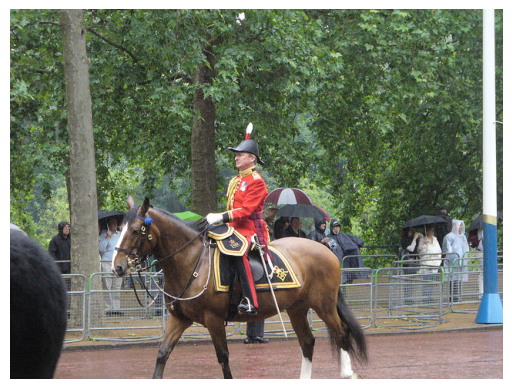

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
image = cv2.imread("input.jpg") #Removed /kaggle/working/ from the path

# Check if the image was loaded correctly
if image is None:
    print("Error: Could not read image. Please check the file path and ensure the image is not corrupted.")
else:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Set device to CPU if CUDA is not available
if not torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24])
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2351, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4209],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3802],
        [335.2410, 251.9167, 414.7491, 275.9376],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]]))


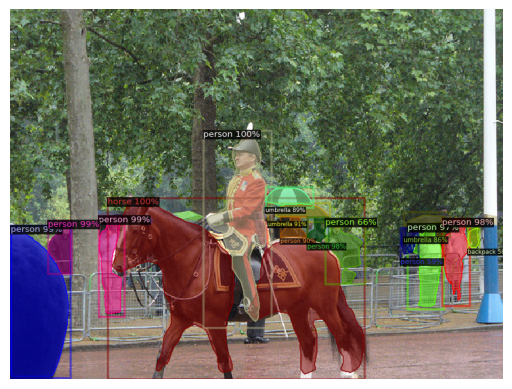

In [ ]:
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2.imshow(out.get_image()[:, :, ::-1])

plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
plt.axis('off')
plt.show()

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Dlwgwe3psTHRPIuQlsbV")
project = rf.workspace("panats-mp-project").project("microplastic-dataset")
dataset = project.version(19).download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Microplastic-Dataset-19 in coco:: 100%|██████████| 787/787 [00:00<00:00, 6467.31it/s]


In [ ]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [ ]:
ANNOTATIONS_FILE_NAME

'_annotations.coco.json'

In [ ]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# # TEST SET
# TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
# TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
# TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

# register_coco_instances(
#     name=TEST_DATA_SET_NAME,
#     metadata={},
#     json_file=TEST_DATA_SET_ANN_FILE_PATH,
#     image_root=TEST_DATA_SET_IMAGES_DIR_PATH
# )

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

In [ ]:
VALID_DATA_SET_ANN_FILE_PATH, TRAIN_DATA_SET_ANN_FILE_PATH

('/content/Microplastic-Dataset-19/valid/_annotations.coco.json',
 '/content/Microplastic-Dataset-19/train/_annotations.coco.json')

In [ ]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Microplastic-Dataset-train', 'Microplastic-Dataset-valid']

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



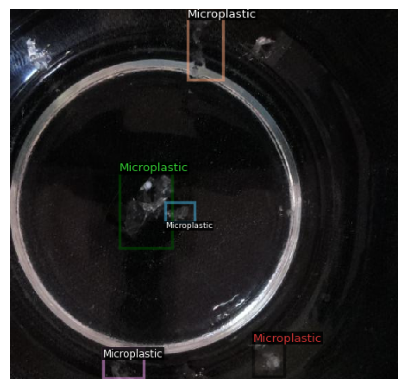

In [ ]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
# cv2.imshow(out.get_image()[:, :, ::-1])

plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
plt.axis('off')
plt.show()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME)
cfg.DATASETS.TEST = ()

# Pre - processing
cfg.INPUT.MIN_SIZE_TRAIN = (800,)  # Minimum size of the input image during training
cfg.INPUT.MAX_SIZE_TRAIN = 1280  # Maximum size of the input image during training

cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 254
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION = 18  # Increase if your objects are very small
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000  # Number of proposals to keep before applying NMS during training
# cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1000  # Number of proposals to keep before applying NMS during testing
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 1000  # Number of proposals to keep after applying NMS during training
# cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 500  # Number of proposals to keep after applying NMS during testing

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.WEIGHT_DECAY = 0.005

In [ ]:
# Set up Detectron2 logger
setup_logger()

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/24 04:29:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 206MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[09/24 04:29:40 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


[09/24 04:29:51 d2.utils.events]:  eta: 0:11:42  iter: 19  total_loss: 2.884  loss_cls: 1.62  loss_box_reg: 0.5577  loss_rpn_cls: 0.5199  loss_rpn_loc: 0.05429    time: 0.3561  last_time: 0.3422  data_time: 0.0191  last_data_time: 0.0054   lr: 1.9981e-05  max_mem: 1843M
[09/24 04:30:01 d2.utils.events]:  eta: 0:11:33  iter: 39  total_loss: 2.559  loss_cls: 1.293  loss_box_reg: 0.7139  loss_rpn_cls: 0.392  loss_rpn_loc: 0.1128    time: 0.3560  last_time: 0.3650  data_time: 0.0094  last_data_time: 0.0147   lr: 3.9961e-05  max_mem: 1843M
[09/24 04:30:09 d2.utils.events]:  eta: 0:11:27  iter: 59  total_loss: 1.735  loss_cls: 0.8304  loss_box_reg: 0.6833  loss_rpn_cls: 0.1754  loss_rpn_loc: 0.09437    time: 0.3564  last_time: 0.3543  data_time: 0.0108  last_data_time: 0.0059   lr: 5.9941e-05  max_mem: 1843M
[09/24 04:30:16 d2.utils.events]:  eta: 0:11:21  iter: 79  total_loss: 1.625  loss_cls: 0.6106  loss_box_reg: 0.7412  loss_rpn_cls: 0.1313  loss_rpn_loc: 0.08117    time: 0.3626  last_ti

In [ ]:
evaluator = COCOEvaluator("Microplastic-Dataset-valid", False, output_dir="/kaggle/working/output/")
val_loader = build_detection_test_loader(cfg, "Microplastic-Dataset-valid")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [09/24 04:46:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/24 04:46:57 d2.data.datasets.coco]: Loaded 204 images in COCO format from /content/Microplastic-Dataset-19/valid/_annotations.coco.json
[09/24 04:46:57 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:------------:|:-------------|
|    MPDS    | 0            | Microplastic | 1701         |
|            |              |              |              |
|   total    | 1701         |              |              |
[09/24 04:46:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/24 04:46:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/24 04:46:57 d2.data.common]: Serializin

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/24 04:46:59 d2.evaluation.evaluator]: Inference done 11/204. Dataloading: 0.0051 s/iter. Inference: 0.1134 s/iter. Eval: 0.0004 s/iter. Total: 0.1189 s/iter. ETA=0:00:22
[09/24 04:47:04 d2.evaluation.evaluator]: Inference done 64/204. Dataloading: 0.0031 s/iter. Inference: 0.0934 s/iter. Eval: 0.0003 s/iter. Total: 0.0970 s/iter. ETA=0:00:13
[09/24 04:47:09 d2.evaluation.evaluator]: Inference done 116/204. Dataloading: 0.0040 s/iter. Inference: 0.0925 s/iter. Eval: 0.0003 s/iter. Total: 0.0969 s/iter. ETA=0:00:08
[09/24 04:47:14 d2.evaluation.evaluator]: Inference done 167/204. Dataloading: 0.0041 s/iter. Inference: 0.0929 s/iter. Eval: 0.0003 s/iter. Total: 0.0975 s/iter. ETA=0:00:03


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/24 04:47:18 d2.evaluation.evaluator]: Total inference time: 0:00:19.478229 (0.097881 s / iter per device, on 1 devices)
[09/24 04:47:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:18 (0.093466 s / iter per device, on 1 devices)
[09/24 04:47:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/24 04:47:18 d2.evaluation.coco_evaluation]: Saving results to /kaggle/working/output/coco_instances_results.json
[09/24 04:47:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[09/24 04:47:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[09/24 04:47:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[09/24 04:47:18 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[09/24 04:47:18 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average P

# UNET

In [ ]:
import pandas as pd

# Load the training and validation annotations
train_annotations = pd.read_csv('/content/drive/MyDrive/marine/Data/train/_annotations.csv')
val_annotations = pd.read_csv('/content/drive/MyDrive/marine/Data/valid/_annotations.csv')

# Check the structure
print(train_annotations.head())
print(val_annotations.head())


                                          filename  width  height  \
0  177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg    563     537   
1  177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg    563     537   
2  177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg    563     537   
3  177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg    563     537   
4  177_jpg.rf.78ce205aa324b8cb17ee4051188b13d5.jpg    563     537   

          class  xmin  ymin  xmax  ymax  
0  Microplastic   102   170   123   196  
1  Microplastic   395   247   424   281  
2  Microplastic   160   254   188   290  
3  Microplastic   187   307   213   346  
4  Microplastic   175   379   209   427  
                                            filename  width  height  \
0  c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...    563     537   
1  c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...    563     537   
2  c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381...    563     537   
3  c--188-_jpg.rf.df8c04f880e507f44d63d74b701f381

In [ ]:
import os
import numpy as np
import cv2

# Define the paths for the images and masks
train_images_dir = '/content/drive/MyDrive/marine/Data/train'
val_images_dir = '/content/drive/MyDrive/marine/Data/valid'

train_mask_dir = '/content/drive/MyDrive/marine/Data/'
val_mask_dir = '/content/drive/MyDrive/marine/Data/'

# Create mask directories if they don't exist
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

def create_mask(image_filename, image_width, image_height, bboxes, mask_dir):
    """
    Create a blank mask and fill bounding boxes.
    """
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        mask = cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=255, thickness=-1)

    mask_path = os.path.join(mask_dir, image_filename.replace('.jpg', '_mask.png'))
    cv2.imwrite(mask_path, mask)

def generate_masks(annotations, images_dir, mask_dir):
    """
    Generate masks for the entire dataset.
    """
    grouped = annotations.groupby('filename')

    for filename, group in grouped:
        # Get the image dimensions and bounding boxes
        width = group.iloc[0]['width']
        height = group.iloc[0]['height']
        bboxes = group[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Create and save the mask
        create_mask(filename, width, height, bboxes, mask_dir)

# Generate masks for training and validation sets
generate_masks(train_annotations, train_images_dir, train_mask_dir)
generate_masks(val_annotations, val_images_dir, val_mask_dir)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare the dataset (images and masks)
def prepare_data(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '_mask.png'))

            # Load and resize images and masks
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

            image = cv2.resize(image, image_size)
            mask = cv2.resize(mask, image_size)

            images.append(image / 255.0)  # Normalize image
            masks.append(mask / 255.0)    # Normalize mask

    return np.array(images), np.array(masks).reshape(-1, image_size[0], image_size[1], 1)

# Prepare training and validation data
train_images, train_masks = prepare_data(train_images_dir, train_mask_dir)
val_images, val_masks = prepare_data(val_images_dir, val_mask_dir)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Down-sampling path (encoder)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling path (decoder)
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=-1)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=-1)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=-1)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=-1)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Instantiate the model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training parameters
batch_size = 8
epochs = 25

# Train the model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=batch_size,
    epochs=epochs
)


Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8742 - loss: 0.3672 - val_accuracy: 0.9402 - val_loss: 0.1997
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 88s 508ms/step - accuracy: 0.9346 - loss: 0.2163 - val_accuracy: 0.9421 - val_loss: 0.2027
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 482ms/step - accuracy: 0.9358 - loss: 0.2033 - val_accuracy: 0.9448 - val_loss: 0.1704
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 486ms/step - accuracy: 0.9390 - loss: 0.1806 - val_accuracy: 0.9420 - val_loss: 0.1742
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 483ms/step - accuracy: 0.9368 - loss: 0.1843 - val_accuracy: 0.9494 - val_loss: 0.1629
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - accuracy: 0.9482 - loss: 0.1526 - val_accuracy: 0.9429 - val_loss: 0.1622
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 503ms/step - accuracy: 0.9421 - loss: 0.1850 - val_accuracy: 0.9547 - val_loss: 0.1385
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 475ms/step - accuracy: 0.9196 - loss: 0.6626 - val_accura

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


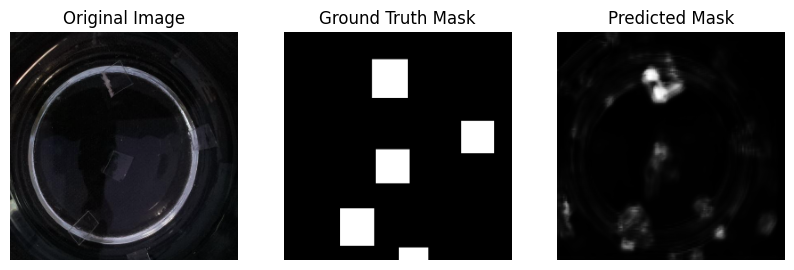

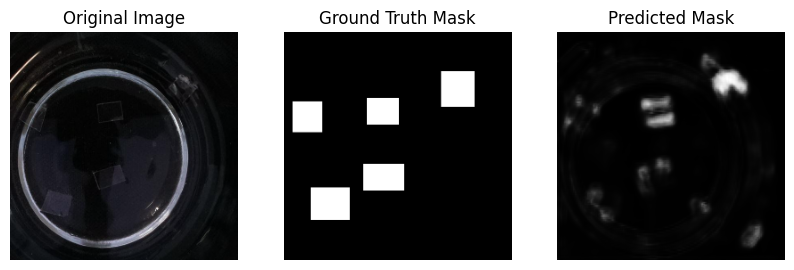

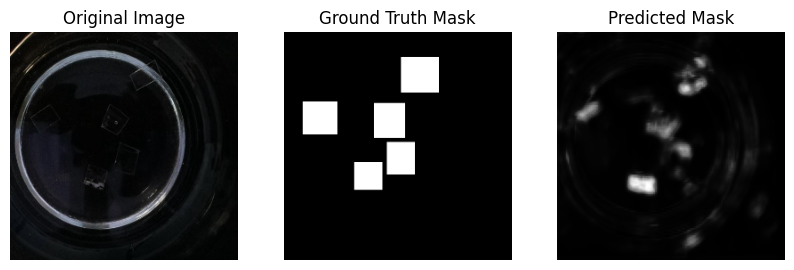

In [ ]:
import matplotlib.pyplot as plt

def display_predictions(model, images, masks, num_samples=3):
    predictions = model.predict(images[:num_samples])

    for i in range(num_samples):
        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Display ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Visualize predictions for validation samples
display_predictions(model, val_images, val_masks)


In [ ]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9581 - loss: 0.1257
Validation Loss: 0.11613709479570389
Validation Accuracy: 0.9603233933448792


# ResNet50

In [ ]:
import os

# Define the paths to your images and masks
train_images_dir = '/content/drive/MyDrive/marine/Data/train'  # Folder with training images
train_mask_dir = '/content/drive/MyDrive/marine/Data'     # Folder with corresponding training masks

val_images_dir = '/content/drive/MyDrive/marine/Data/valid'      # Folder with validation images
val_mask_dir = '/content/drive/MyDrive/marine/Data'         # Folder with corresponding validation masks


In [ ]:
import numpy as np
import cv2
import os

def prepare_data(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    # Load images and corresponding masks
    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '_mask.png'))

            # Load and resize images and masks
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

            # Resize images and masks to the target size
            image = cv2.resize(image, image_size)
            mask = cv2.resize(mask, image_size)

            # Normalize the image and mask
            images.append(image / 255.0)
            masks.append(mask / 255.0)

    return np.array(images), np.array(masks).reshape(-1, image_size[0], image_size[1], 1)

# Load the training and validation data
train_images, train_masks = prepare_data(train_images_dir, train_mask_dir)
val_images, val_masks = prepare_data(val_images_dir, val_mask_dir)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def create_resnet_segmentation_model(input_size=(256, 256, 3)):
    # Load the ResNet50 model pre-trained on ImageNet, without the top fully connected layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model for segmentation
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(base_model.output)
    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    #Corrected Upsampling to match input size
    x = layers.UpSampling2D(size=(4, 4))(x)

    # Final layer: Predicts one channel (binary mask)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Define the final model
    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model

# Instantiate the model
resnet_segmentation_model = create_resnet_segmentation_model()

# Compile the model for segmentation tasks
resnet_segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
resnet_segmentation_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 28,693,889 (109.46 MB)

 Trainable params: 5,106,177 (19.48 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Training parameters
batch_size = 16
epochs = 25

# Train the ResNet50 segmentation model
history = resnet_segmentation_model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=batch_size,
    epochs=epochs
)


Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 572ms/step - accuracy: 0.8125 - loss: 0.5963 - val_accuracy: 0.9402 - val_loss: 0.2254
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9319 - loss: 0.2454 - val_accuracy: 0.9402 - val_loss: 0.2214
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9256 - loss: 0.2612 - val_accuracy: 0.9402 - val_loss: 0.2224
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9294 - loss: 0.2474 - val_accuracy: 0.9402 - val_loss: 0.2171
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9337 - loss: 0.2313 - val_accuracy: 0.9402 - val_loss: 0.2155
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9298 - loss: 0.2401 - val_accuracy: 0.9402 - val_loss: 0.2161
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9330 - loss: 0.2349 - val_accuracy: 0.9402 - val_loss: 0.2156
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9343 - loss: 0.2254 - val_accuracy: 0.9

In [ ]:
# Evaluate the model on the validation set
val_results = resnet_segmentation_model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_results[0]}, Validation Accuracy: {val_results[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9417 - loss: 0.2085
Validation Loss: 0.20913659036159515, Validation Accuracy: 0.940186083316803


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


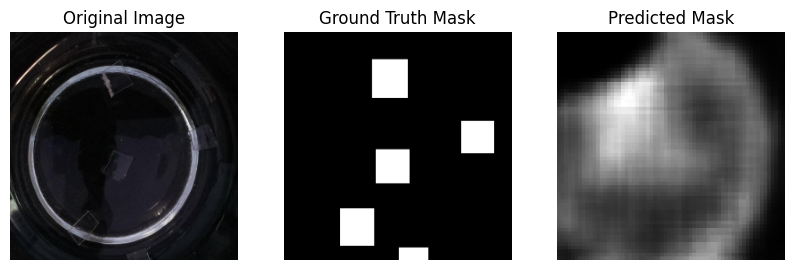

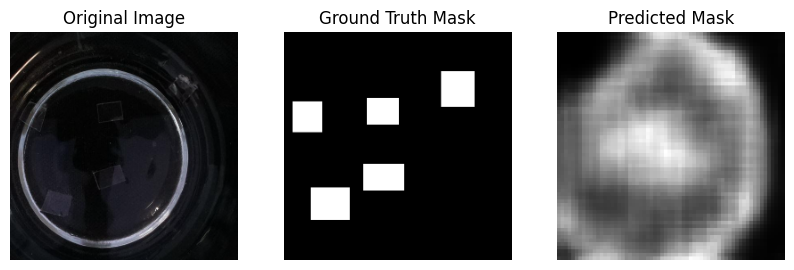

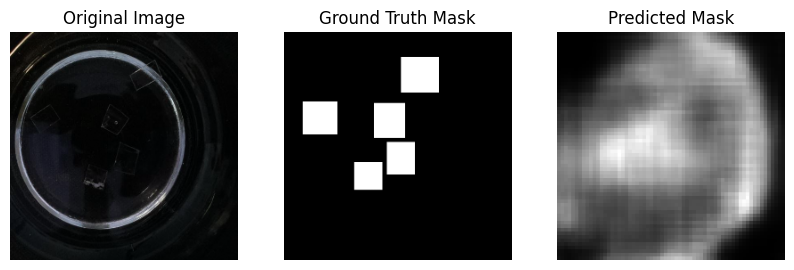

In [ ]:
import matplotlib.pyplot as plt

def display_segmentation_predictions(model, images, masks, num_samples=3):
    predictions = model.predict(images[:num_samples])

    for i in range(num_samples):
        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis("off")

        # Display ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Visualize predictions for validation samples
display_segmentation_predictions(resnet_segmentation_model, val_images, val_masks)


# Architecture faster rcnn

In [ ]:
+-------------------+       +---------------+
|    Input Image     | ----> |   ResNet-50    |
+-------------------+       +---------------+
                                 |
                                 v
                        +---------------+
                        |     FPN       |
                        +---------------+
                                 |
                                 v
                 +-----------------------------------+
                 |      Region Proposal Network      |
                 +-----------------------------------+
                                 |
                                 v
                     +--------------------------+
                     |      ROI Align           |
                     +--------------------------+
                                 |
                                 v
     +----------------------+          +----------------------------+
     | Classification Head  |          |  Bounding Box Regression    |
     +----------------------+          +----------------------------+
                |                                  |
                v                                  v
        +------------------+            +----------------------------+
        |  Class Prediction |            |  Refined Bounding Box      |
        +------------------+            +----------------------------+
